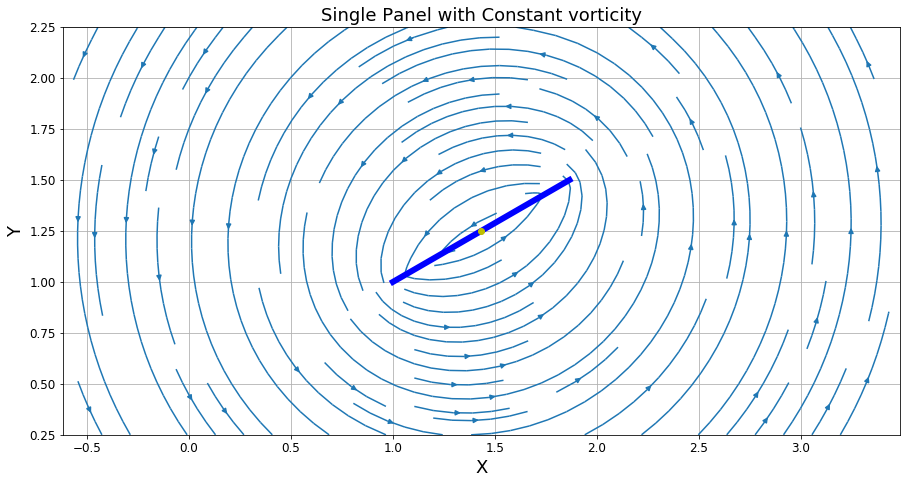

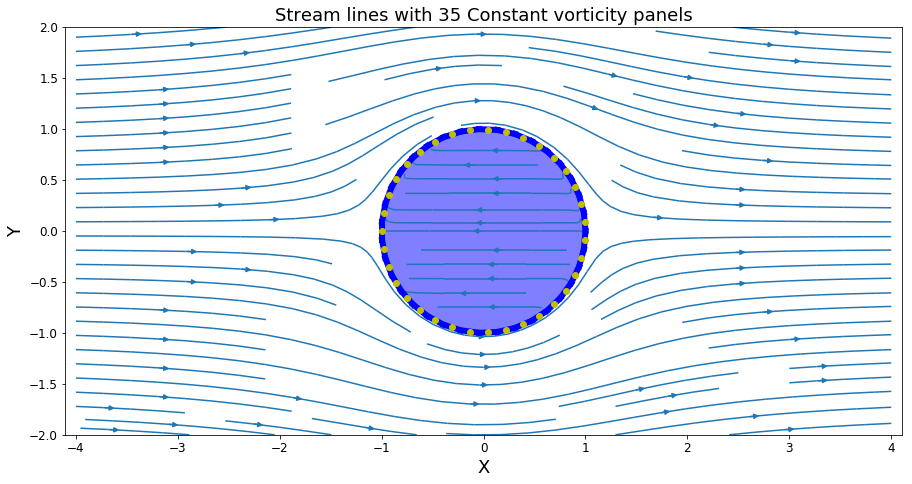

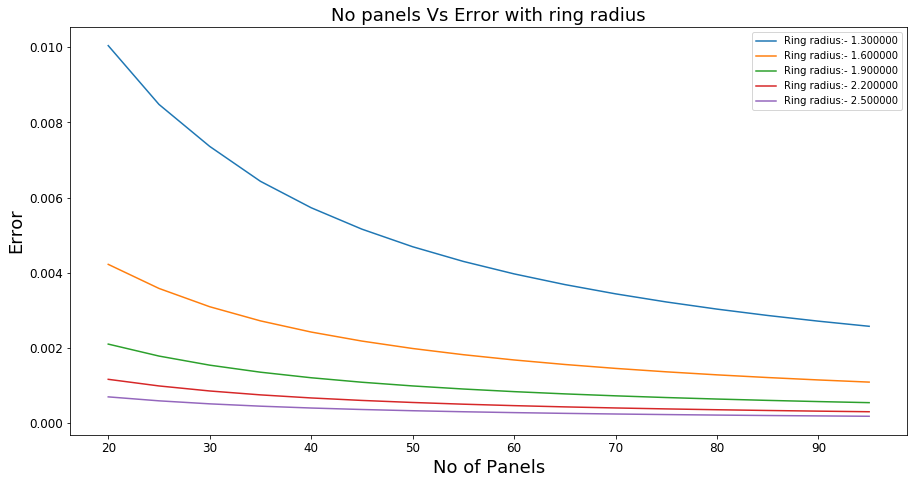

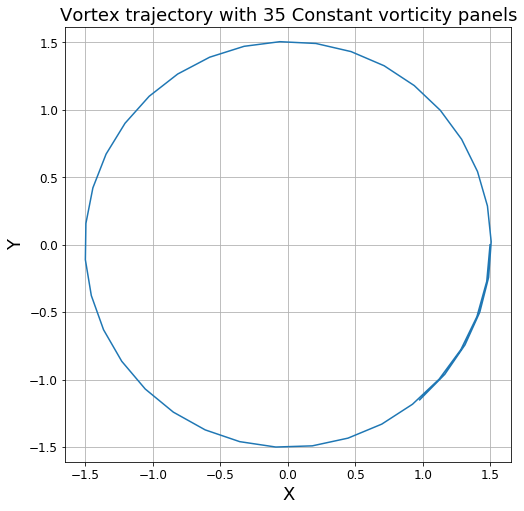

In [115]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
# plt.ion()

V = complex(0,0)

class Panel:
    def __init__(self,start,end,strength=0):
        self.start=start
        self.end=end
        self.l=np.abs(end-start)
        self.t=((self.end-self.start)/abs(self.end-self.start))
        self.contol_point=0.5*(self.start+self.end)
        self.strength=strength
        
#         self.theta=np.arctan2((self.end.imag-self.start.imag),(self.end.real-self.start.real))
        
    def vortexpanel_coeff(self,field):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_coef=1j/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.coeff=complex_coef.conjugate()
        return complex_coef.conjugate()
    
    def vortexpanel_vel(self,field,strength):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_vel=1j*strength/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.complex_vel=complex_vel.conjugate()
        return complex_vel.conjugate()

    
    def panel_normal(self,origin):
        self.normal=(self.contol_point-origin)/np.abs(self.contol_point-origin)

    def draw(self):
        plt.plot([self.start.real,self.end.real],[self.start.imag,self.end.imag],linewidth=6,c='#0000ff')
        plt.plot(self.contol_point.real,self.contol_point.imag,'o',c='y')
        
        
def vortex_vel(z, vortex_pos, vortex_str):
    return (-1j*vortex_str/(2*np.pi*(z - vortex_pos))).conjugate()

def source_vel(z, source_pos, source_str):
    return (source_str*np.log(z - source_pos)).conjugate() 


def vel_linear_strength(z,l):
    vel_z_prime1 = ((1j/(2*np.pi))*(((z - l)/l)*np.log((z - l)/z) + 1))\
    .conjugate() #-1j
    vel_z_prime2 = ((-1j/(2*np.pi))*((z/l)*np.log((z - l)/z) + 1))\
    .conjugate() #-1*j 
    return vel_z_prime1,vel_z_prime2        

def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def single_panel(angle=0):
    plt.close('all')

    gamma=1.0
    angles=np.linspace(0,180,11)
    # plt.figure(figsize=(15,15))
    # for angle in angels:


#     angle=25
    start=complex(1.0,1.0)
    end=complex(start.real+np.cos(angle*np.pi/180),start.imag+np.sin(angle*np.pi/180))
    
    c=0.5*(start+end)

    z = create_mesh(x_low=c.real-2,x_up=c.real+2,n_x=100, y_low=c.imag-1,y_up=c.imag+1,n_y=100)

    P=Panel(start,end)
    P.vortexpanel_vel(z,gamma)
    plt.figure(figsize=(15,7.5))
    P.draw()
    complex_vel = P.complex_vel+V#+freestream_phi(V,z) + 

    plt.streamplot(z.real,z.imag,complex_vel.real,complex_vel.imag)
    plt.axis('equal')
    plt.grid('on')
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Single Panel with Constant vorticity',fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    

def complex_mult(a,b):
    return a.real*b.real+a.imag*b.imag

def assemble_coeff_mat(Ps):
    no_panels=len(Ps)
    cm=np.zeros([no_panels+1,no_panels],dtype=complex)
    for i in range(no_panels):
        for j in range(no_panels):
            cm[i,j]=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point),Ps[i].normal)
#     print(np.shape(cm))
    return cm

def assemble_b_mat(Ps,V, vortex_pos=[0.0+0.0j], vortex_str=[0.0+0.0j], source_pos=[0.0+0.0j], source_str=[0.0+0.0j]):
    no_panels=len(Ps)
    bm=np.zeros([no_panels+1,1],dtype=complex)
    for i in range(no_panels):
        v_source = 0.0 + 0.0j
        for j, z in enumerate(source_pos):
            v_source += source_vel(Ps[i].contol_point, z, source_str[j])
        v_vortex = 0.0 + 0.0j
        for j, z in enumerate(vortex_pos):
            v_vortex += vortex_vel(Ps[i].contol_point, z, vortex_str[j])
        
        V_final=V + v_source + v_vortex
        bm[i]=-complex_mult(V_final,Ps[i].normal)
        
#     print(np.shape(bm))
    return bm

def generate_panels(no_panels,radius,origin):
    radians = np.linspace(0,2*np.pi,no_panels+1) 
    points = origin + radius*(np.cos(radians) +1j*np.sin(radians))
    end = points[1:]
    start = points[:-1]

#     plt.figure(figsize=(15,7.5))
    Ps=[]
    for i in range(no_panels):
        Ps.append(Panel(start[i],end[i]))
        Ps[i].panel_normal(origin)
#         Ps[i].draw()
    return Ps

def rk2_integrate(z,z_src,vort_gama,Vinf, dt ,tf,Ps,cm):
    result = [z]
    t = 0.0
    while t < tf:
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k1 = vel*dt
        z += k1
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k2 = vel*dt
        z += 0.5*(-k1 + k2) 
        result.append(z.copy()) 
        t += dt
#         print t,z
    return np.asarray(result)

def get_velocity(Ps,Vinf,vortex_pos,vortex_str,cm):
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    bm[-1]=0.0
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    Comple_vel=Vinf
    for i in range(len(Ps)):
        Ps[i].vortexpanel_vel(vortex_pos,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel
       
    return Comple_vel


def problem1(n,r):
    no_panels=n
    radius=r
    origin=complex(0,0)
    Vinf=complex(1.0,0)

    z = create_mesh(x_low=-4+origin.real,x_up=4+origin.real,n_x=100, y_low=-2+origin.imag,y_up=2+origin.imag,n_y=100)

    Ps=generate_panels(no_panels,radius,origin)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf).real
    
# """Since the matrix is ill conditioned it has infinite soutions, 
#     it can be solved only by adding circulation condition
#     Circulation condition as below"""

    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

#     gamma_mat=np.linalg.solve(cm,bm)
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    # print(gamma_mat)

    Comple_vel=Vinf
    for i in range(no_panels):
        Ps[i].vortexpanel_vel(z,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel

    plt.figure(figsize=(15,7.5))    

    plt.streamplot(z.real,z.imag,Comple_vel.real,Comple_vel.imag)
    plt.axis('equal')
    for i in range(no_panels):
        Ps[i].draw()
    circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#0000ff', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Stream lines with %d Constant vorticity panels'%no_panels,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


def points_generate(num_points,pcr,center):
    radians = np.linspace(0,2*np.pi,num_points+1)[:-1] 
    points = center + pcr*(np.cos(radians) +1j*np.sin(radians))
    return points,radians
    
def exact_vel(points,radians,Vinf,cr,pcr):
    Vr=np.abs(Vinf)*(1-cr**2/pcr**2)*np.cos(radians)
    Vt=-np.abs(Vinf)*(1+cr**2/pcr**2)*np.sin(radians)
    Vexact=np.sqrt(Vr**2+Vt**2)
    return Vexact
        
def error_constant_vortex():
    plt.figure(figsize=(15,7.5))
    num_points=200
    n_panels=np.asarray(range(20,100,5))

    pcrs=np.linspace(1,2.5,6)[1:]
    for pcr in pcrs:
        error=[]
        for no_panels in n_panels:
            radius=1.0
            origin=complex(10,10)
            Vinf=complex(1.0,0)


            z,t = points_generate(num_points,pcr,origin)

            Ps=generate_panels(no_panels,radius,origin)

            cm=assemble_coeff_mat(Ps)
            bm=assemble_b_mat(Ps,Vinf).real

            for i in range(no_panels):
                cm[-1,i]=Ps[i].l
            bm[-1]=0

            gamma_mat=np.linalg.lstsq(cm,bm)[0]

            Comple_vel=Vinf
            for i in range(no_panels):
                Ps[i].vortexpanel_vel(z,gamma_mat[i])
                Comple_vel+=Ps[i].complex_vel

            points,radians=points_generate(num_points,pcr,complex(0,0))
            Vexact=exact_vel(points,radians,Vinf,radius,pcr)
            err=np.abs(Comple_vel)-Vexact
#             error.append(np.sqrt(sum(err**2)/num_points))

            error.append(sum(np.abs(Comple_vel)-Vexact)/num_points)

        plt.plot(n_panels,error,label='Ring radius:- %f'%pcr)        
    plt.xlabel('No of Panels',fontsize=18)
    plt.ylabel('Error',fontsize=18)
    plt.title('No panels Vs Error with ring radius',fontsize=18)
    plt.legend(loc=1,fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    return error,n_panels

def traj(no_panels,radius,dt,tf,origin=complex(0,0),Vinf=complex(0,0),
         vortex_pos=[0+0j], vortex_str=[0.0],source_pos=[0+0j],source_str=[0.0]):
      
    t=0

    Ps=generate_panels(no_panels,radius,origin)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    result=rk2_integrate(vortex_pos,vortex_pos,vortex_str,Vinf, dt ,tf,Ps,cm)
    plt.figure(figsize=(8,8))
    plt.axis('equal')
    plt.plot(result.real,result.imag)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Vortex trajectory with %d Constant vorticity panels'%no_panels,fontsize=18)
#     plt.legend(loc=1,fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    
    return result


# plt.show()

if __name__ == '__main__':
    single_panel(angle=30)
    problem1(35,1)
    error,n_panels=error_constant_vortex()
    result=traj(35,1.0,0.5,20.0,vortex_pos=[1.5+0j],vortex_str=[2*np.pi])
    plt.show()


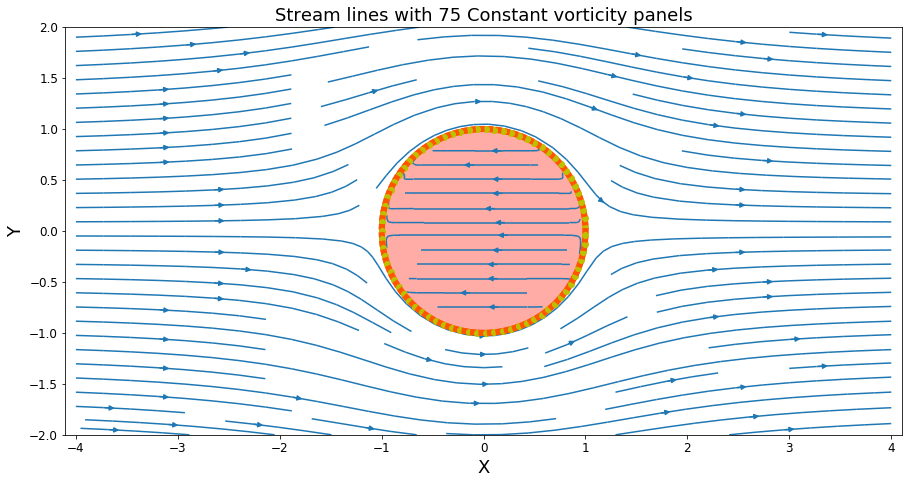

In [91]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
# plt.ion()

V = complex(0,0)

class Panel:
    def __init__(self,start,end,strength=0):
        self.start=start
        self.end=end
        self.l=np.abs(end-start)
        self.t=((self.end-self.start)/abs(self.end-self.start))
        self.contol_point=0.5*(self.start+self.end)
        self.strength=strength
        
#         self.theta=np.arctan2((self.end.imag-self.start.imag),(self.end.real-self.start.real))
        
    def vortexpanel_coeff(self,field):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_coef=1j/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.coeff=complex_coef.conjugate()
        return complex_coef.conjugate()
    
    def vortexpanel_vel(self,field,strength):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_vel=1j*strength/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.complex_vel=complex_vel.conjugate()
        return complex_vel.conjugate()

    def vel_linear_strength(self,field):
        coeff1 = ((1j/(2*np.pi))*(((field - self.l)/self.l)*np.log((field - self.l)/field) + 1))\
        .conjugate() #-1j
        coeff2 = ((-1j/(2*np.pi))*((field/self.l)*np.log((field - self.l)/field) + 1))\
        .conjugate() #-1*j 
        self.coeff1=coeff1
        self.coeff2=coeff2
        return coeff1,coeff2

    
    def panel_normal(self,origin):
        self.normal=(self.contol_point-origin)/np.abs(self.contol_point-origin)

    def draw(self):
        plt.plot([self.start.real,self.end.real],[self.start.imag,self.end.imag],linewidth=6,c='#ff5500')
        plt.plot(self.contol_point.real,self.contol_point.imag,'o',c='y')
        

def vortex_vel(z, vortex_pos, vortex_str):
    return (-1j*vortex_str/(2*np.pi*(z - vortex_pos))).conjugate()

def source_vel(z, source_pos, source_str):
    return (source_str*np.log(z - source_pos)).conjugate() 
    
def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def complex_mult(a,b):
    return a.real*b.real+a.imag*b.imag

def assemble_coeff_mat(Ps):
    no_panels=len(Ps)
    cm=np.zeros([no_panels+1,no_panels],dtype=complex)
    for i in range(no_panels):
        for j in range(no_panels):
            cm[i,j]=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point),Ps[i].normal)
#     print(np.shape(cm))
    return cm

def matrix_a(Ps):
    no_panels=len(Ps)
    cm=np.zeros([no_panels+1,no_panels],dtype=complex)
    for i in range(no_panels):
        for j in range(no_panels):
            rotate1 = np.exp(1.0j*panels[j%n].angle)               
            mid_new1 = (panels[i].mid - panels[j%n].start)/rotate1               
            v_ij_1 = -1.0j*(1.0 + (mid_new1/panels[j%n].length - 1.0)*np.log(1.0 - panels[j%n].length/mid_new1))/(2.0*np.pi)
            rotate2 = np.exp(1.0j*panels[(j-1)%n].angle)
            mid_new2 = (panels[i].mid - panels[(j-1)%n].start)/rotate2               
            v_ij_2 = 1.0j*(1.0 + (mid_new2/panels[(j-1)%n].length)*np.log(1.0 - panels[(j-1)%n].length/mid_new2))/(2.0*np.pi)
            v_ij = v_ij_1.conjugate()*rotate1 + v_ij_2.conjugate()*rotate2
            a[i][j] = (v_ij.conjugate()*panels[i].normal).real
    a[n][:] = 1.0
    return cm


def assemble_b_mat(Ps,V, vortex_pos=[0.0+0.0j], vortex_str=[0.0], source_pos=[0.0+0.0j], source_str=[0.0]):
    no_panels=len(Ps)
    bm=np.zeros([no_panels+1,1],dtype=complex)
    for i in range(no_panels):
        v_source = 0.0 + 0.0j
        for j, z in enumerate(source_pos):
            v_source += source_vel(Ps[i].contol_point, z, source_str[j])
        v_vortex = 0.0 + 0.0j
        for j, z in enumerate(vortex_pos):
            v_vortex += vortex_vel(Ps[i].contol_point, z, vortex_str[j])
        
        V_final=V + v_source + v_vortex
        bm[i]=-complex_mult(V_final,Ps[i].normal)
        
#     print(np.shape(bm))
    return bm

def generate_panels(no_panels,radius,origin):
    radians = np.linspace(0,2*np.pi,no_panels+1) 
    points = origin + radius*(np.cos(radians) +1j*np.sin(radians))
    end = points[1:]
    start = points[:-1]

#     plt.figure(figsize=(15,7.5))
    Ps=[]
    for i in range(no_panels):
        Ps.append(Panel(start[i],end[i]))
        Ps[i].panel_normal(origin)
#         Ps[i].draw()
    return Ps

def points_generate(num_points,pcr,center):
    radians = np.linspace(0,2*np.pi,num_points+1)[:-1] 
    points = center + pcr*(np.cos(radians) +1j*np.sin(radians))
    return points,radians
    
def exact_vel(points,radians,Vinf,cr,pcr):
    Vr=np.abs(Vinf)*(1-cr**2/pcr**2)*np.cos(radians)
    Vt=-np.abs(Vinf)*(1+cr**2/pcr**2)*np.sin(radians)
    Vexact=np.sqrt(Vr**2+Vt**2)
    return Vexact
        
def single_panel(angle=0):
    plt.close('all')

    gamma=1.0
    angles=np.linspace(0,180,11)
    start=complex(1.0,1.0)
    end=complex(start.real+np.cos(angle*np.pi/180),start.imag+np.sin(angle*np.pi/180))
    
    c=0.5*(start+end)

    z = create_mesh(x_low=c.real-2,x_up=c.real+2,n_x=100, y_low=c.imag-1,y_up=c.imag+1,n_y=100)

    P=Panel(start,end)
    P.vortexpanel_vel(z,gamma)
    plt.figure(figsize=(15,7.5))
    P.draw()
    complex_vel = P.complex_vel+V#+freestream_phi(V,z) + 

    plt.streamplot(z.real,z.imag,complex_vel.real,complex_vel.imag)
    plt.axis('equal')
    plt.grid('on')
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Single Panel with Constant vorticity',fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

def problem1(n,r):
    no_panels=n
    radius=r
    origin=complex(0,0)
    Vinf=complex(1.0,0)

    z = create_mesh(x_low=-4+origin.real,x_up=4+origin.real,n_x=100, y_low=-2+origin.imag,y_up=2+origin.imag,n_y=100)

    Ps=generate_panels(no_panels,radius,origin)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf).real
    
    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

#     gamma_mat=np.linalg.solve(cm,bm)
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
#     print(gamma_mat)

    Comple_vel=Vinf
    for i in range(no_panels):
        Ps[i].vortexpanel_vel(z,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel

    plt.figure(figsize=(15,7.5))    

    plt.streamplot(z.real,z.imag,Comple_vel.real,Comple_vel.imag)
    plt.axis('equal')
    for i in range(no_panels):
        Ps[i].draw()
    circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#ff1100', alpha=0.35)
    plt.gca().add_patch(circle)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Stream lines with %d Constant vorticity panels'%no_panels,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


def for_error():
    plt.figure(figsize=(15,7.5))
    num_points=200
    n_panels=np.asarray(range(20,100,5))

    pcrs=np.linspace(1,2.5,6)[1:]
    for pcr in pcrs:
        error=[]
        for no_panels in n_panels:
            radius=1.0
            origin=complex(10,10)
            Vinf=complex(1.0,0)


            z,t = points_generate(num_points,pcr,origin)

            Ps=generate_panels(no_panels,radius,origin)

            cm=assemble_coeff_mat(Ps)
            bm=assemble_b_mat(Ps,Vinf).real

            for i in range(no_panels):
                cm[-1,i]=Ps[i].l
            bm[-1]=0

            gamma_mat=np.linalg.lstsq(cm,bm)[0]

            Comple_vel=Vinf
            for i in range(no_panels):
                Ps[i].vortexpanel_vel(z,gamma_mat[i])
                Comple_vel+=Ps[i].complex_vel

            points,radians=points_generate(num_points,pcr,complex(0,0))
            Vexact=exact_vel(points,radians,Vinf,radius,pcr)
            err=np.abs(Comple_vel)-Vexact
#             error.append(np.sqrt(sum(err**2)/num_points))

            error.append(sum(np.abs(Comple_vel)-Vexact)/num_points)

        plt.plot(n_panels,error,label='Ring radius:- %f'%pcr)        
    plt.xlabel('No of Panels',fontsize=18)
    plt.ylabel('Error',fontsize=18)
    plt.title('No panels Vs Error with ring radius',fontsize=18)
    plt.legend(loc=1,fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    return error,n_panels
# plt.show()

if __name__ == '__main__':
    single_panel(angle=30)
    problem1(75,1)
    error,n_panels=for_error()
    plt.show()


In [108]:
def rk2_integrate(z,z_src,vort_gama,Vinf, dt ,tf,Ps,cm):
    result = [z]
    t = 0.0
    while t < tf:
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k1 = vel*dt
        z += k1
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k2 = vel*dt
        z += 0.5*(-k1 + k2) 
        result.append(z.copy()) 
        t += dt
#         print t,z
    return np.asarray(result)

def get_velocity(Ps,Vinf,vortex_pos,vortex_str,cm):
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    bm[-1]=0.0
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    Comple_vel=Vinf
    for i in range(len(Ps)):
        Ps[i].vortexpanel_vel(vortex_pos,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel
       
    return Comple_vel

def traj(no_panels,radius,dt,tf,origin=complex(0,0),Vinf=complex(0,0),
         vortex_pos=[0+0j], vortex_str=[0.0],source_pos=[0+0j],source_str=[0.0]):
      
    t=0

    Ps=generate_panels(no_panels,radius,origin)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    result=rk2_integrate(vortex_pos,vortex_pos,vortex_str,Vinf, dt ,tf,Ps,cm)
    plt.plot(result.real,result.imag)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Vortex trajectory',fontsize=18)
#     plt.legend(loc=1,fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
        
    
    
    
traj(35,1.0,0.1,30.0,vortex_pos=[1.5+0j],vortex_str=[2*np.pi])

